In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas_datareader as web

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [276]:
### Get Data
MACRO = {
'DGS1MO' : 'y_1M',
'DGS3MO' : 'y_3M',
'DGS6MO' : 'y_6M',
'DGS1'   : 'y_1Y', 
'DGS2'   : 'y_2Y',  
'DGS3'   : 'y_3Y',  
'DGS5'   : 'y_5Y',  
'DGS7'   : 'y_7Y',  
'DGS10'  : 'y_10Y', 
'DGS20'  : 'y_20Y', 
'DGS30'  : 'y_30Y', 
    
'BAMLC0A1CAAA'  : 'COAS_AAA',
'BAMLC0A2CAA'   : 'COAS_AA',
'BAMLC0A3CA'    : 'COAS_A',
'BAMLC0A4CBBB'  : 'COAS_BBB',
'BAMLH0A1HYBB'  : 'COAS_BB', 
'BAMLH0A2HYB'   : 'COAS_B',  
'BAMLH0A3HYC'   : 'COAS_CCC_lower',  
'BAMLC0A0CM'    : 'IG_OAS',  
'BAMLH0A0HYM2'  : 'HY_OAS',  
'BAMLC1A0C13Y'  : 'IG_1_3Y', 
'BAMLC2A0C35Y'  : 'IG_3_5Y',
'BAMLC3A0C57Y'  : 'IG_5_7Y',
'BAMLC4A0C710Y' : 'IG_7_10Y', 
'BAMLC7A0C1015Y': 'IG_10_15Y', 
'BAMLC8A0C15PY' : 'IG_15_PlusY', 

'T5YIE'   :'BEI_5_Y', 
#'T5YIFR'  :'5Y_FBEI',
'T7YIEM'  :'BEI_7_Y', 
'T10YIE'  :'BEI_10_Y',
'T20YIEM' :'BEI_20_Y',
'T30YIEM' :'BEI_30_Y',
}

yields = (
    web.DataReader(MACRO.keys(), 'fred', start='18540101', end=pd.Timestamp.now())
    .interpolate(method="polynomial", order=1, axis=0)
)
yields = yields.rename(columns=MACRO)

TICKERS = [
    '^GSPC','^DJI','^NDX','^RUT',
    'TLT','TIP','^TNX',
    '^VIX','^VVIX',
    #'^VIX1D','^VIX9D','^VIX3M','^VIX6M','^VIX1Y'
]
NAMES = [
    'SP500','DJI','ND100','RU2000',
    'TLT','TIPS','RF10y',
    'VIX','VVIX',
    #'VIX1D','VIX9D','VIX3M','VIX6M','VIX1Y'
]

prices = yf.download(TICKERS, interval='1d', period='max')['Close'].rename(dict(zip(TICKERS,NAMES)),axis=1)
# calculate realized volatility
rolling_window = 21
prices['SP500_RV'] = np.log(prices['SP500'] / prices['SP500'].shift(1)).rolling(window=rolling_window).std() * np.sqrt(252) * 100
prices['SP500_rolling_mdd'] = (prices['SP500'] / prices['SP500'].rolling(rolling_window, min_periods=rolling_window).max() - 1) * 100
data = pd.concat([yields, prices], axis=1)
data.index = pd.to_datetime(data.index)
data = data.apply(pd.to_numeric)
#data = data.loc['1996-12-31':]
data = data.interpolate(method="linear", axis=0)

[*********************100%***********************]  9 of 9 completed


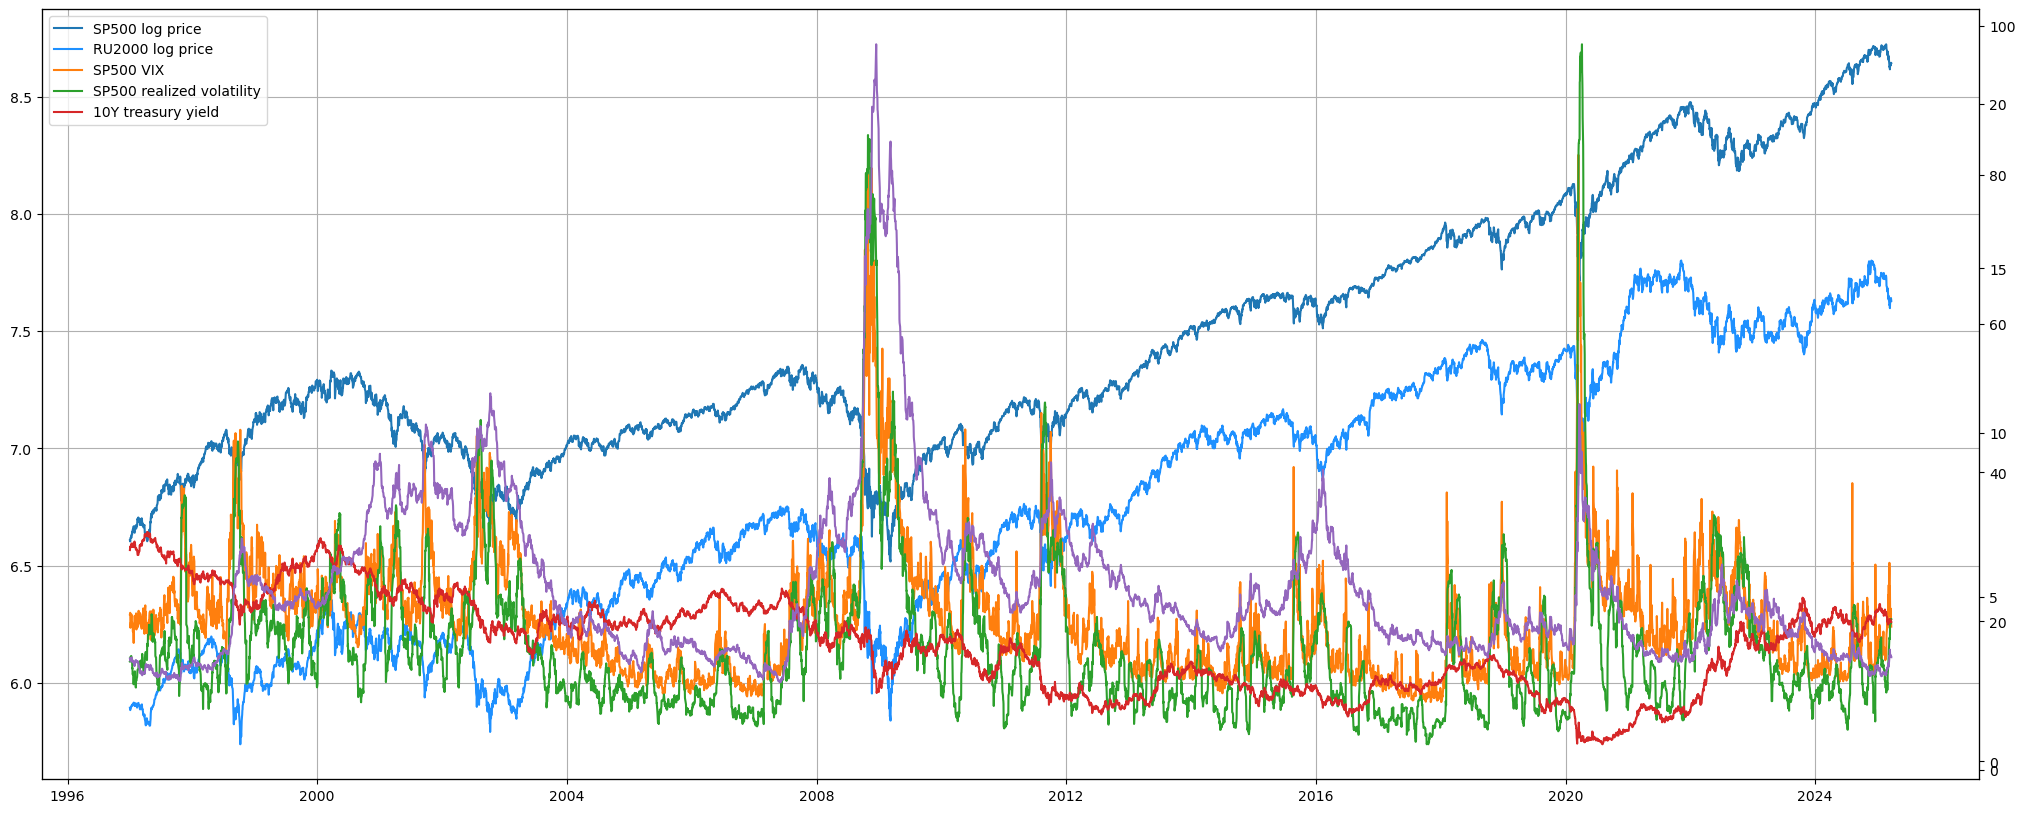

In [418]:
subset = data[['SP500','RU2000','VIX','SP500_RV','y_10Y','HY_OAS']].dropna()

fig,ax = plt.subplots(figsize=(25,10))
ax0 = ax.twinx()
ax1 = ax.twinx()
line0, = ax.plot(subset.SP500.apply(np.log), label='SP500 log price')
line1, = ax.plot(subset.RU2000.apply(np.log), label='RU2000 log price', c='dodgerblue')
line2, = ax0.plot(subset.VIX, c='tab:orange', label='SP500 VIX')
line3, = ax0.plot(subset.SP500_RV, c='tab:green', label='SP500 realized volatility')
line4, = ax1.plot(subset.y_10Y, c='tab:red', label='10Y treasury yield')
line5, = ax1.plot(subset.HY_OAS, c='tab:purple', label='HY option-adjusted spread')

ax.grid()
# Combine legends
lines = [line0, line1, line2, line3, line4]  # Collect line objects
labels = [line.get_label() for line in lines]  # Extract labels
ax.legend(lines, labels, loc="upper left") ;

In [419]:
# (prices['SP500'] / prices['SP500'].rolling(rolling_window, min_periods=rolling_window).max() - 1).plot()
# (prices['SP500'] / prices['SP500'].cummax() - 1).rolling(rolling_window, min_periods=rolling_window).min().plot()

realized_1mo_returns    -7.355267
realized_1mo_vol        20.254223
Name: 2025-03-21 00:00:00, dtype: float64

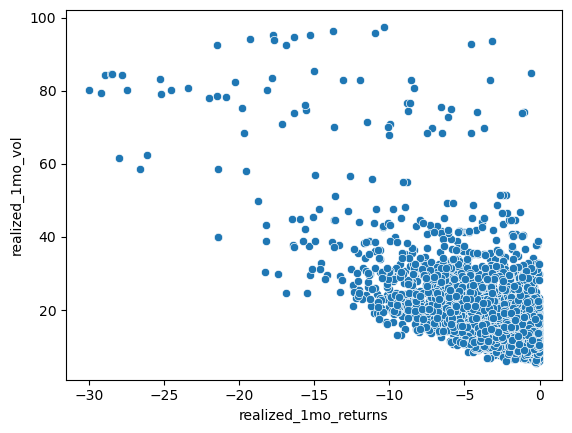

In [524]:
def static_reg(returns, y_asset, X_factors):
    returns = returns[[y_asset] + X_factors].dropna()
    X = returns[X_factors]
    y = returns[y_asset]
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

def rolling_reg(returns, y_asset, X_factors, window):
    returns = returns[[y_asset] + X_factors].dropna()
    X = returns[X_factors]
    y = returns[y_asset]
    model = RollingOLS(y, sm.add_constant(X), window=window, min_nobs=window).fit()
    
    return model

# realized index vol and returns
realized_1mo_returns = 100 * (subset.SP500 / subset.SP500.shift(rolling_window) - 1)
realized_vol_analysis_df = pd.concat([realized_1mo_returns.rename('realized_1mo_returns'), subset.SP500_RV.rename('realized_1mo_vol')], axis=1).dropna()
sns.scatterplot(realized_vol_analysis_df[realized_vol_analysis_df.realized_1mo_returns < 0], x='realized_1mo_returns', y='realized_1mo_vol');
realized_vol_analysis_df.iloc[-1]

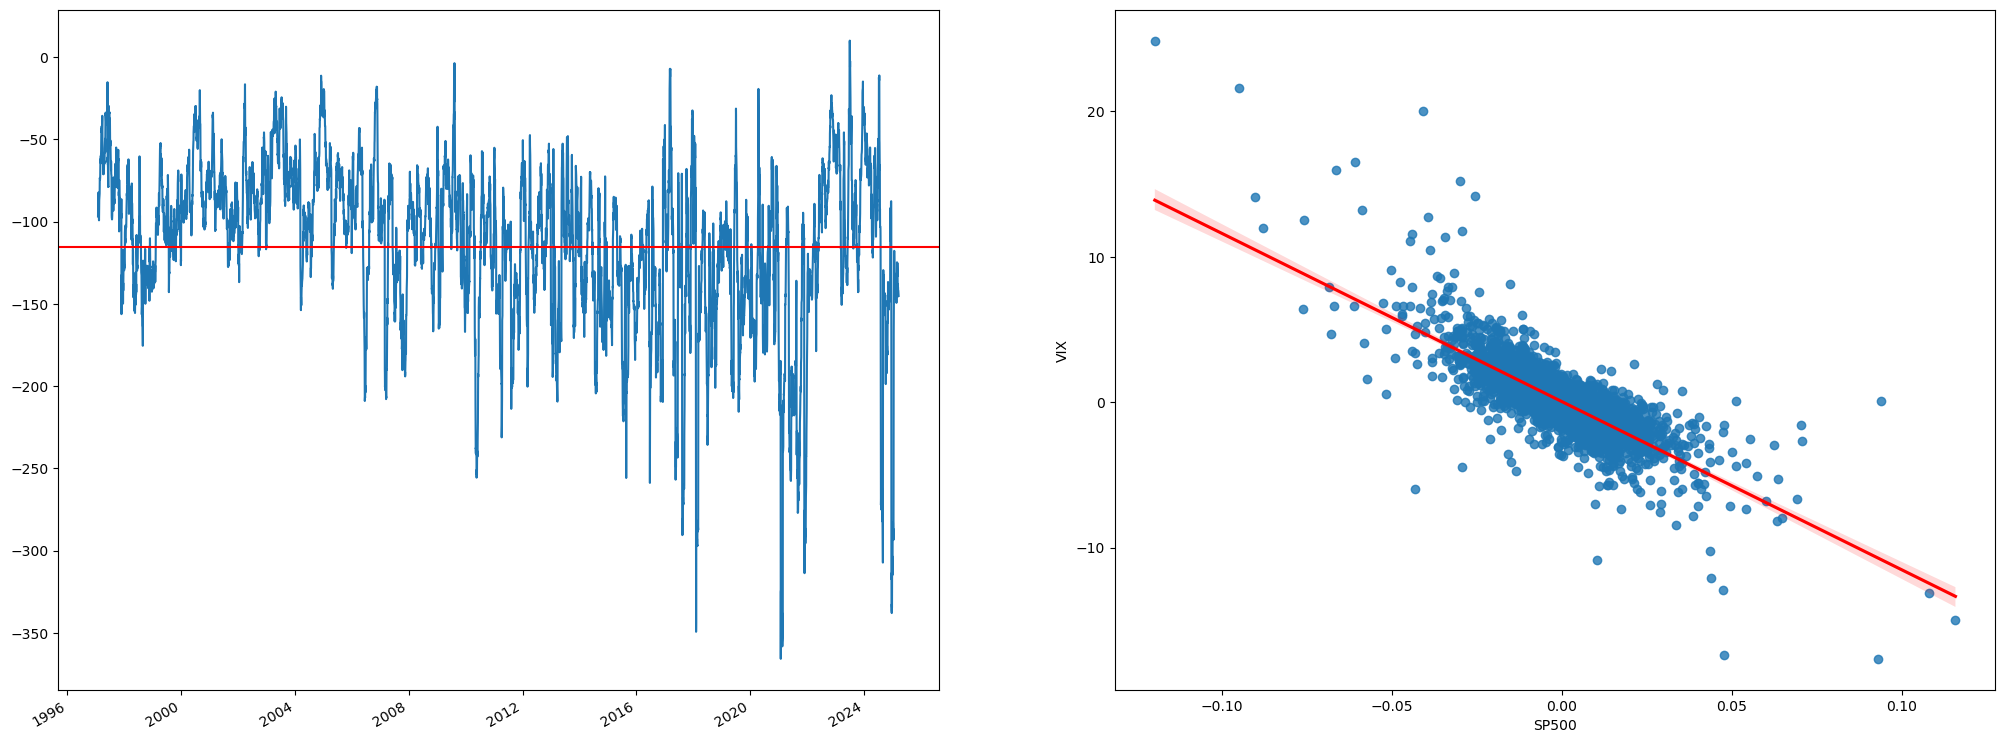

In [744]:
# SP500 index returns
returns = subset.pct_change().iloc[1:]
# VIX is in pct, take diff in pct rather than pct of change in pct (bps)
returns.VIX = (subset.VIX - subset.VIX.shift(1)).iloc[1:]
ols = static_reg(returns, y_asset='VIX', X_factors=['SP500'])
rols = rolling_reg(returns, y_asset='VIX', X_factors=['SP500'], window=rolling_window)

fig,ax = plt.subplots(1,2, figsize=(25,10))
rols.params.SP500.plot(ax=ax[0])
ax[0].axhline(ols.params.SP500, c='red');
sns.regplot(returns, x='SP500', y='VIX', ax=ax[1], line_kws={'color':'red'});

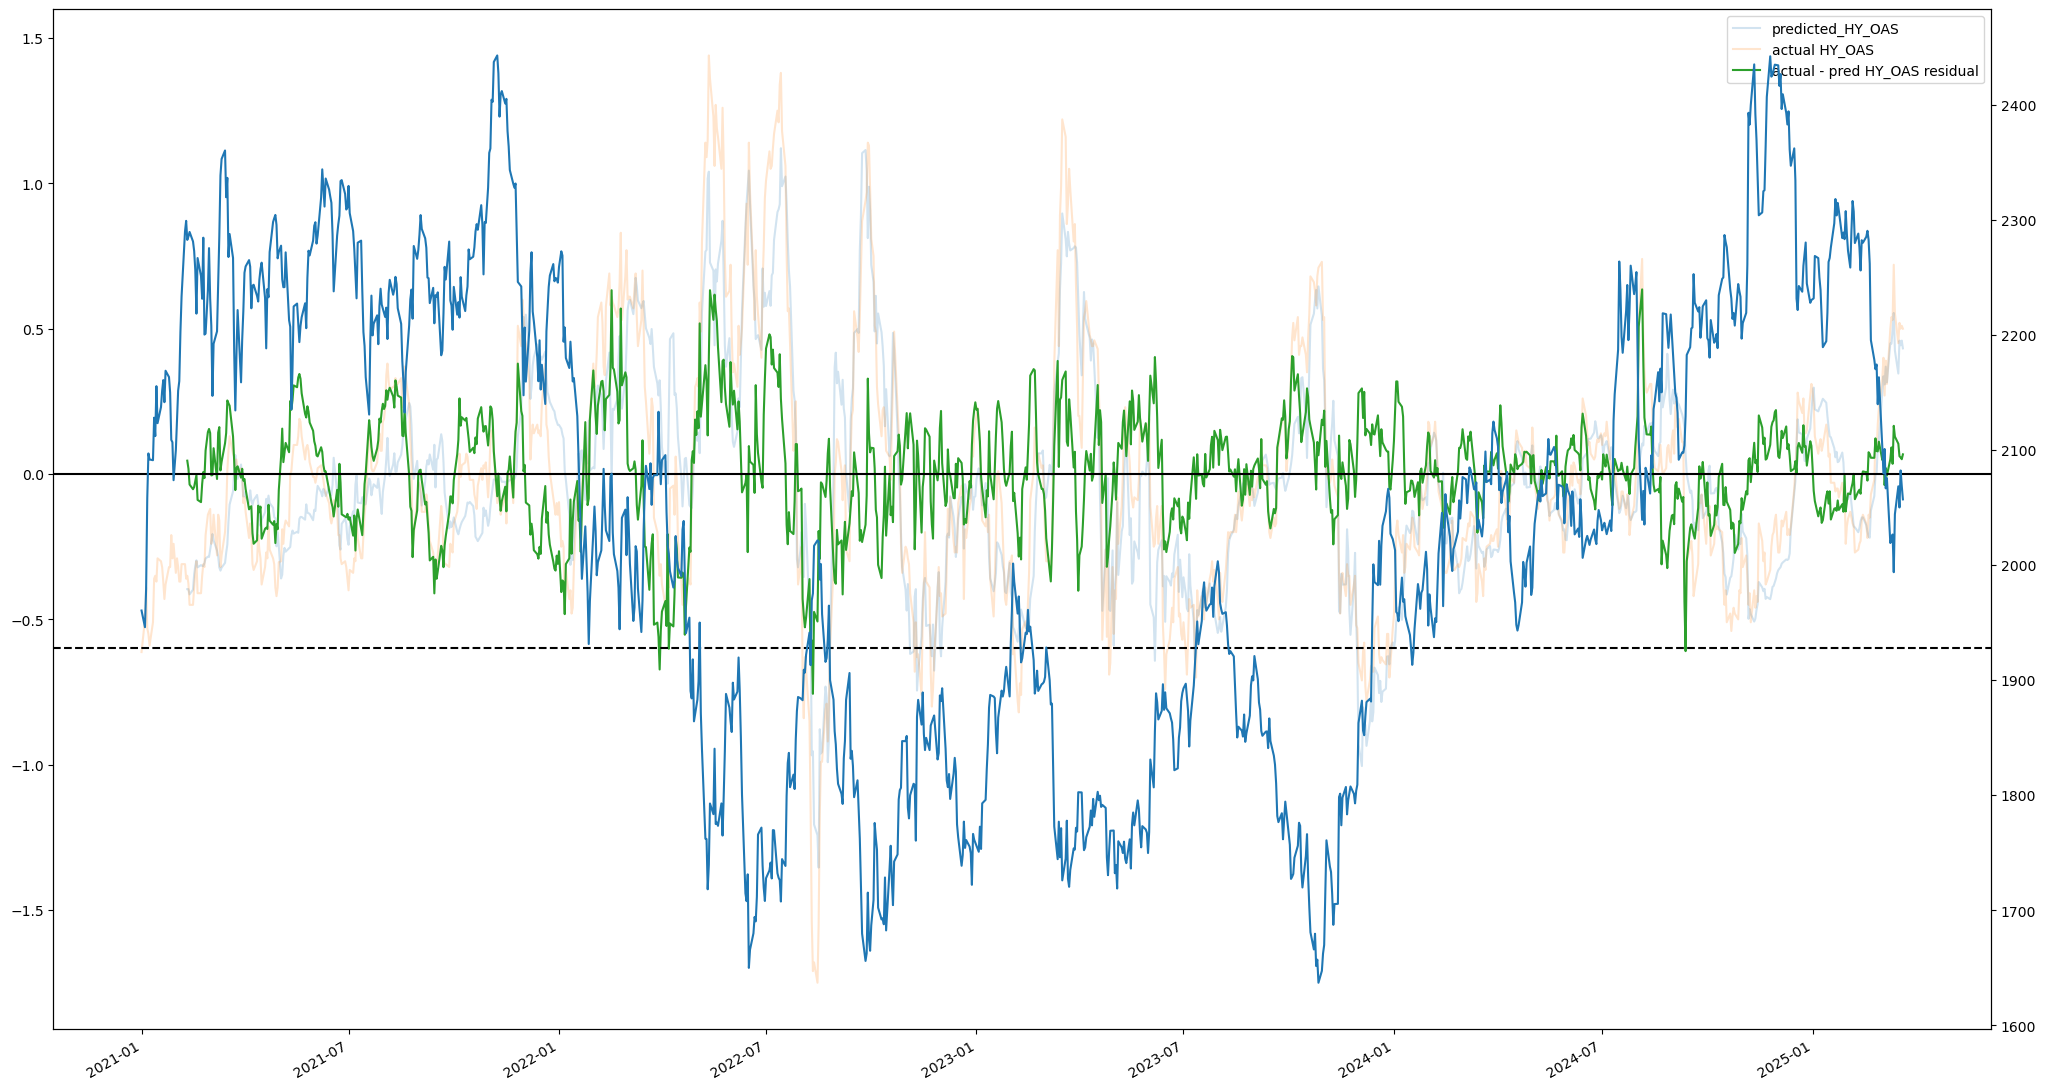

In [812]:
START_ANALYSIS = '2021-01-01'
rolling_window = 30
model_data = subset[['RU2000','HY_OAS']]
# russell 2000 index returns
model_data_ret = (model_data / model_data.shift(rolling_window) - 1).dropna().loc[START_ANALYSIS:]
# for HY_OAS, units in pct so take diff of pct (bps)
model_data_ret.HY_OAS = (model_data.HY_OAS - model_data.HY_OAS.shift(rolling_window)).dropna().loc[START_ANALYSIS:]

ols = static_reg(model_data_ret, y_asset='HY_OAS', X_factors=['RU2000'])
rols = rolling_reg(model_data_ret, y_asset='HY_OAS', X_factors=['RU2000'], window=rolling_window)

# small cap price drop -> RU2000 underperform -> HY OAS increase
predicted_HY_OAS = rols.params.const + rols.params.RU2000 * model_data_ret.RU2000
HY_OAS_residuals = model_data_ret.HY_OAS - predicted_HY_OAS # actual - pred

fig,ax = plt.subplots(figsize=(25,15))
ax0 = ax.twinx()
model_data.RU2000.loc[START_ANALYSIS:].plot(ax=ax0, label='RU2000')
predicted_HY_OAS.plot(ax=ax, label='predicted_HY_OAS', alpha=0.2)
model_data_ret.HY_OAS.plot(ax=ax, label='actual HY_OAS', alpha=0.2)
HY_OAS_residuals.plot(ax=ax, label='actual - pred HY_OAS residual')
ax.axhline(0, c='black')
ax.axhline(-0.60, c='black', ls='--')
ax.legend();